계획은 아래와 같음.

0. 데이터 불러오기
1. 데이터 확인
2. 데이터 전처리
3. 데이터 feature 파악
4. train data를 feature와 label로 나눠서 모델 생성하고 학습시키기 (이 때 학습에 사용하는 feature는 3번에서 파악한 feature 상위 6개로)
5. logistic, lightgbm 모델 사용
6. 5번 결과 중 가장 좋은 모델을 test 데이터에 적용하기
7. submission

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

### 0. 데이터 불러오기

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s4e7/sample_submission.csv')

### 1. 데이터 확인

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB


In [5]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [6]:
train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [7]:
test.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

### 2. 데이터 전처리

In [8]:
label_encoder_gender = LabelEncoder()
label_encoder_vehicle_age = LabelEncoder()
label_encoder_vehicle_damage = LabelEncoder()

# 훈련 데이터만 사용하여 LabelEncoder 학습
label_encoder_gender.fit(train['Gender'])
label_encoder_vehicle_age.fit(train['Vehicle_Age'])
label_encoder_vehicle_damage.fit(train['Vehicle_Damage'])

# 훈련 데이터 변환
train['Gender'] = label_encoder_gender.transform(train['Gender'])
train['Vehicle_Age'] = label_encoder_vehicle_age.transform(train['Vehicle_Age'])
train['Vehicle_Damage'] = label_encoder_vehicle_damage.transform(train['Vehicle_Damage'])

### 3. 데이터 feature 파악

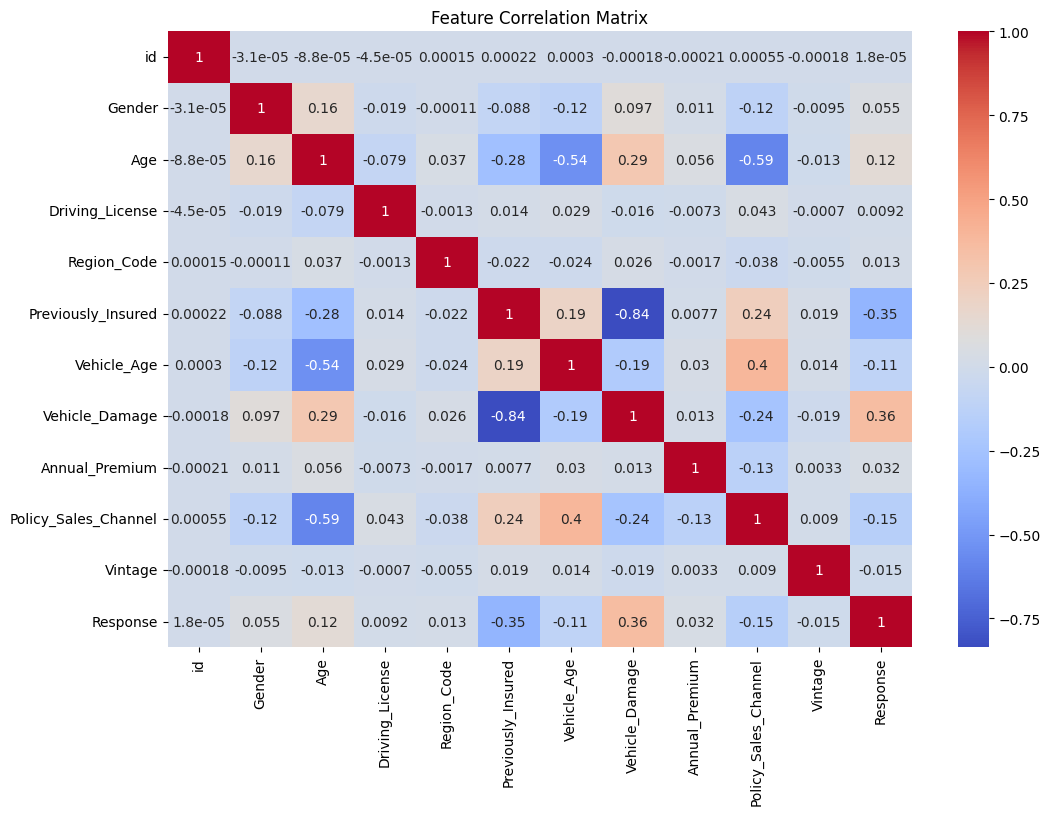

Top features: Index(['Vehicle_Damage', 'Previously_Insured', 'Policy_Sales_Channel', 'Age',
       'Vehicle_Age', 'Gender'],
      dtype='object')


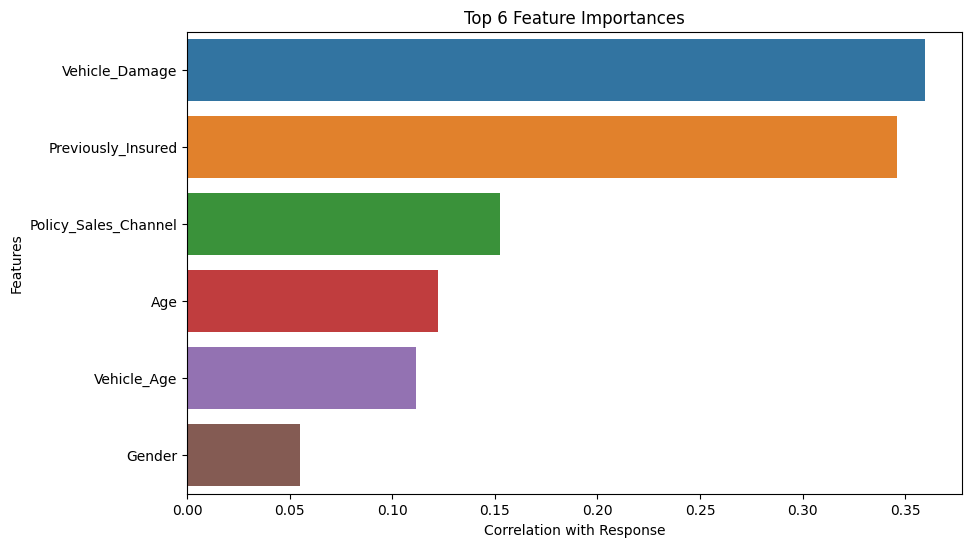

In [9]:
correlations = train.corr()

# 히트맵으로 상관계수 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

top_features = correlations['Response'].abs().sort_values(ascending=False).index[1:7]
print("Top features:", top_features)

# 상위 6개 피처의 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.loc[top_features, 'Response'].abs(), y=top_features)
plt.title('Top 6 Feature Importances')
plt.xlabel('Correlation with Response')
plt.ylabel('Features')
plt.show()

### 4. 모델 생성 및 학습

In [10]:
X = train[top_features]
y = train['Response']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
lr_model = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='saga',
    max_iter=100,
    class_weight='balanced',
    random_state=42,
    verbose=1
)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict_proba(X_val)[:, 1]
lr_roc_auc = roc_auc_score(y_val, lr_pred)

lgb_model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=6,
    num_leaves=31,  # 기본값 31 사용
    min_data_in_leaf=20,  # 리프 노드의 최소 데이터
    min_sum_hessian_in_leaf=1e-3,  # 리프 노드의 최소 헷시안 합
    subsample=0.8,  # 데이터 샘플링 비율
    colsample_bytree=0.8,  # 특성 샘플링 비율
    max_bin=255,  # 최대 분할 개수
    force_row_wise=True,
    random_state=42
)

lgb_model.fit(X_train, y_train)

lgb_pred = lgb_model.predict_proba(X_val)[:, 1]
lgb_roc_auc = roc_auc_score(y_val, lgb_pred)

convergence after 18 epochs took 87 seconds
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1131875, number of negative: 8071963
[LightGBM] [Info] Total Bins 182
[LightGBM] [Info] Number of data points in the train set

### 5. 모델 성능 확인

In [11]:
print(f"Logistic Regression ROC AUC: {lr_roc_auc}")
print(f"LightGBM ROC AUC: {lgb_roc_auc}")

Logistic Regression ROC AUC: 0.8241229027206447
LightGBM ROC AUC: 0.8601972767065448


### 6. 테스트 데이터에 모델 적용

In [12]:
class SafeLabelEncoder(LabelEncoder):
    def transform(self, y):
        try:
            return super().transform(y)
        except ValueError:
            return np.array([-1] * len(y))

label_encoder_gender = SafeLabelEncoder()
label_encoder_vehicle_age = SafeLabelEncoder()
label_encoder_vehicle_damage = SafeLabelEncoder()

label_encoder_gender.fit(list(train['Gender'].astype(str)) + list(test['Gender'].astype(str)))
label_encoder_vehicle_age.fit(list(train['Vehicle_Age'].astype(str)) + list(test['Vehicle_Age'].astype(str)))
label_encoder_vehicle_damage.fit(list(train['Vehicle_Damage'].astype(str)) + list(test['Vehicle_Damage'].astype(str)))

test['Gender'] = label_encoder_gender.transform(test['Gender'].astype(str))
test['Vehicle_Age'] = label_encoder_vehicle_age.transform(test['Vehicle_Age'].astype(str))
test['Vehicle_Damage'] = label_encoder_vehicle_damage.transform(test['Vehicle_Damage'].astype(str))

best_model = None
if lr_roc_auc > lgb_roc_auc:
    best_model = lr_model
else:
    best_model = lgb_model

test_data = test[top_features]
test_pred = best_model.predict_proba(test_data)[:, 1]

# 7. submission
submission['Response'] = test_pred
submission.to_csv('submission.csv', index=False)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
